In [12]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBRegressor, XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import pandas as pd
import numpy as np
import datetime
import plotly.express as px

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import time

In [13]:
!python3 --version

Python 3.8.10


# 1. Regression

## 1.1. Data normalization and splitting

In [14]:
dfRegression = pd.read_pickle('data/instaSeer_dfRegression.pkl')
dfRegression.head()

imageRatio  numOfHashtags  numOfTaggedUsers  lenOfCaption  uploadDayOfWeek  \
0    0.800593              3                 0           393                5   
1    0.800000              1                 0           493                4   
2    0.800000              4                 4           381                3   
3    0.852407             11                 4          1066                2   
4    0.841121              3                14           438                1   

   airplane  apple  backpack  bear  bed  ...       r_2       r_3       r_4  \
0         0      0         0     0    0  ...  0.088276  0.065703  0.044500   
1         0      0         0     0    0  ...  0.083768  0.100007  0.085263   
2         0      0         0     0    0  ...  0.126595  0.147534  0.140920   
3         0      0         0     0    0  ...  0.121562  0.102008  0.072295   
4         0      0         0     0    0  ...  0.134287  0.149030  0.096407   

        r_5       r_6       r_7       r_8       r_9  weightedLikes  \
0  0.037190  0.038341  0.040815  0.048398  0.123412       0.008045   
1  0.091560  0.205126  0.221063  0.109176  0.027279       0.005776   
2  0.135176  0.118555  0.095936  0.059841  0.035946       0.022759   
3  0.180454  0.103579  0.090273  0.053849  0.036595       0.012241   
4  0.071352  0.062300  0.056218  0.041762  0.016706       0.019843   

   logWeightedLikes  
0         -4.822688  
1         -5.154068  
2         -3.782799  
3         -4.402979  
4         -3.919906  

[5 rows x 107 columns]

In [15]:
# 0 – no hashtags
# 1 – from 1 to 6
# 2 – more than 6
def code(x):
    if x == 0:
        return 0
    elif x>=1 and x<6:
        return 1
    else: 
        return 2
dfRegression['numOfHashtags'] = dfRegression['numOfHashtags'].apply(lambda x: code(x))


In [16]:
# 0 – no tagged users
# 1 – 1 tagged user
# 2 – more than 1 tagged users
def code2(x):
    if x == 0:
        return 0
    elif x==1:
        return 1
    else: 
        return 2
dfRegression['numOfTaggedUsers'] =dfRegression['numOfTaggedUsers'].apply(lambda x: code2(x))

In [17]:
featureNames = list(dfRegression.columns)
featureNames.remove('weightedLikes')
featureNames.remove('logWeightedLikes')

In [18]:
X, y = dfRegression[featureNames], dfRegression[['logWeightedLikes']]

In [19]:
featureNames = X.columns
featureNames

Index(['imageRatio', 'numOfHashtags', 'numOfTaggedUsers', 'lenOfCaption',
       'uploadDayOfWeek', 'airplane', 'apple', 'backpack', 'bear', 'bed',
       ...
       'r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'r_9'],
      dtype='object', length=105)

In [20]:
# mms = MinMaxScaler()
# Xsc = mms.fit_transform(X)
#y = np.log(y)
# ssc = StandardScaler()
# y = ssc.fit_transform(y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y).reshape(-1), test_size=0.2)

In [22]:
def regressionReport(y_true, y_pred, plotName = int(time.time())):
    """
    The function produces regression report based on provided real and predicted values
    Input:
    y_true (1-D iterable): real values
    y_pred (1-D iterable): predicted values
    
    Output:
    None, plot and metrics are printed out
    """
    #Sanity check of means
    print('True mean value \t:', np.mean(y_true))
    print('Predicted mean value \t:', np.mean(y_true))
    print('MSE \t\t\t:', mean_squared_error(y_true, y_pred))
    print('RMSE \t\t\t:', mean_squared_error(y_true, y_pred, squared=False))
    sigm = np.sqrt(mean_squared_error(y_true, y_pred)*len(y_true)/(len(y_true)-1))
    print('3sigma \t\t\t:', 3 * sigm)
    print('Var. coeff. \t\t:', np.abs(sigm/np.mean(y_pred)))
    print('Var. coeff. (3 sigma) \t:', np.abs(3*sigm/np.mean(y_pred)))
    print('R2-score\t\t:', r2_score(y_true, y_pred))

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Predicted vs Real", "Residuals histogram"))
    # Add traces
    fig.add_trace(go.Scatter(x=y_true, y=y_pred,mode='markers'), row=1, col=1)
    fig.add_trace(go.Histogram(x=(np.array(y_true)-np.array(y_pred))), row=1, col=2)

    # Update xaxis properties
    fig.update_xaxes(title_text="Real values", row=1, col=1)
    fig.update_xaxes(title_text="Residuals", row=1, col=2)

    # Update yaxis properties
    fig.update_yaxes(title_text="Predicted values", row=1, col=1)
#     fig.update_yaxes(title_text="yaxis 2 title", range=[40, 80], row=1, col=2)

    # Update title and height
    fig.update_layout(autosize=False,
        width=800,
        height=400, showlegend = False, title = plotName)
    fig.show()
    fig.write_html(str(plotName)+'.html')
                     
def getNimportantFeatures(model, n = 15):
    """The function returns n first important features according to a model with feature_importances_ property.
    Input:
    model (sklearn model): fitted model
    n (int):               number of features 
    
    Output:
    pandas dataframe
    """
    dfFeatureImportances = pd.DataFrame()
    dfFeatureImportances['feature'] = featureNames
    dfFeatureImportances['importance'] = model.feature_importances_
    return dfFeatureImportances.sort_values(by='importance', ascending = False).head(n)

## 1.2 RandomForestRegressor

In [23]:
rfr = RandomForestRegressor()

n_estimators = [int(x) for x in np.linspace(start = 20, stop = 400, num = 10)]

max_features = ['auto', 'sqrt'] +[10*(i+1) for i in range(4)]

max_depth = [int(x) for x in np.linspace(10, 200, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 5, 7, 10]

bootstrap = [True]
parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rsrfr = RandomizedSearchCV(rfr, parameters)
rsrfr.fit(X_train, np.array(y_train).reshape(-1))
rsrfr.best_params_

/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home

/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home

/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/inotin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:572: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home

{'n_estimators': 315,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 40,
 'max_depth': 86,
 'bootstrap': True}

In [65]:
y_pred = rsrfr.best_estimator_.predict(X_train).reshape(-1)
regressionReport(y_train, y_pred)

True mean value 	: -4.352108932794245
Predicted mean value 	: -4.352108932794245
MSE 			: 0.1740715257709635
RMSE 			: 0.4172187984390966
3sigma 			: 1.2518191912333476
Var. coeff. 		: 0.09589309041849138
Var. coeff. (3 sigma) 	: 0.28767927125547416
R2-score		: 0.7463015816846295


In [66]:
y_pred = rsrfr.best_estimator_.predict(X_test).reshape(-1)
regressionReport(y_test, y_pred)

True mean value 	: -4.363061774783179
Predicted mean value 	: -4.363061774783179
MSE 			: 0.489099159089365
RMSE 			: 0.6993562461931437
3sigma 			: 2.099160061794233
Var. coeff. 		: 0.1613754467895194
Var. coeff. (3 sigma) 	: 0.4841263403685581
R2-score		: 0.2531734522947351


## 1.3. XGBRegressor

In [67]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_train)
regressionReport(y_train, y_pred, 'XGBRegressor_train')

y_pred = xgbr.predict(X_test)
regressionReport(y_test, y_pred, 'XGBRegressor_test')

True mean value 	: -4.352108932794245
Predicted mean value 	: -4.352108932794245
MSE 			: 0.03942566931310256
RMSE 			: 0.19855898195020683
3sigma 			: 0.5957544222047038
Var. coeff. 		: 0.04563003280856955
Var. coeff. (3 sigma) 	: 0.13689009842570865
R2-score		: 0.9425395399881799


/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



True mean value 	: -4.363061774783179
Predicted mean value 	: -4.363061774783179
MSE 			: 0.565072337869222
RMSE 			: 0.751712935813414
3sigma 			: 2.25631183160666
Var. coeff. 		: 0.17329781369787733
Var. coeff. (3 sigma) 	: 0.519893441093632
R2-score		: 0.13716673714929262


In [68]:
xgbr = XGBRegressor()

parameters={"learning_rate": [0.05, 0.10, 0.15],
            "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15, 20],
            "min_child_weight": [ 1, 3, 5, 7, 10],
            "gamma":[ 0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
            "colsample_bytree":[0.3, 0.4, 0.5, 0.6],}
rsxgbr = RandomizedSearchCV(xgbr, param_distributions=parameters)
rsxgbr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copie

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copie

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None...
                                          validate_parameters=None,
                                          verbosity=None),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'cols

In [69]:
rsxgbr.best_params_

{'min_child_weight': 7,
 'max_depth': 12,
 'learning_rate': 0.05,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

In [70]:
print('Train set')
print('-'*50)
y_pred = rsxgbr.best_estimator_.predict(X_train)
regressionReport(y_train, y_pred, 'rsXGBRegressor_train')

print('Test set')
print('-'*50)
y_pred = rsxgbr.best_estimator_.predict(X_test)
regressionReport(y_test, y_pred,'XGBoost Regressor Results')

Train set
--------------------------------------------------
True mean value 	: -4.352108932794245
Predicted mean value 	: -4.352108932794245
MSE 			: 0.06952674264947956
RMSE 			: 0.2636792419768374
3sigma 			: 0.7911406117638056
Var. coeff. 		: 0.061090509389410436
Var. coeff. (3 sigma) 	: 0.18327152816823133
R2-score		: 0.8986690984486385


/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Test set
--------------------------------------------------
True mean value 	: -4.363061774783179
Predicted mean value 	: -4.363061774783179
MSE 			: 0.4840798163812945
RMSE 			: 0.6957584468630579
3sigma 			: 2.0883610495523657
Var. coeff. 		: 0.1617531819104285
Var. coeff. (3 sigma) 	: 0.48525954573128555
R2-score		: 0.2608377026144397


/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [71]:
getNimportantFeatures(rsxgbr.best_estimator_)

feature  importance
0         imageRatio    0.100105
1      numOfHashtags    0.080488
2   numOfTaggedUsers    0.038135
48            person    0.037846
8               bear    0.036608
16              bowl    0.035806
20               car    0.031263
27               cup    0.030229
28      dining table    0.029373
68             train    0.024714
12              bird    0.024319
71          umbrella    0.024273
21               cat    0.018648
3       lenOfCaption    0.018127
13              boat    0.017771

In [72]:
import pickle
filename = 'models/xgbr_1.pkl'
pickle.dump(rsxgbr.best_estimator_, open(filename, 'wb'))

## 1.4. KNeighborsRegressor

In [85]:
knr = KNeighborsRegressor()
params = {'n_neighbors':[5*i for i in range(1,21)], 
          'weights':['uniform', 'distance'], 
          'leaf_size':[20+i*5 for i in range(5)]}
gsknr = GridSearchCV(knr, params)
gsknr.fit(X_train, y_train) 

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'leaf_size': [20, 25, 30, 35, 40],
                         'n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                         55, 60, 65, 70, 75, 80, 85, 90, 95,
                                         100],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [86]:
gsknr.best_params_

{'leaf_size': 20, 'n_neighbors': 100, 'weights': 'uniform'}

In [87]:
print('Train set')
print('-'*50)
y_pred = gsknr.best_estimator_.predict(X_train)
regressionReport(y_train, y_pred)

print('Test set')
print('-'*50)
y_pred = gsknr.best_estimator_.predict(X_test)
regressionReport(y_test, y_pred)

Train set
--------------------------------------------------
True mean value 	: -4.352108932794245
Predicted mean value 	: -4.352108932794245
MSE 			: 0.6690660544518783
RMSE 			: 0.8179645801939582
3sigma 			: 2.4542129047557655
Var. coeff. 		: 0.18790762279065942
Var. coeff. (3 sigma) 	: 0.5637228683719783
R2-score		: 0.02487785402486986


Test set
--------------------------------------------------
True mean value 	: -4.363061774783179
Predicted mean value 	: -4.363061774783179
MSE 			: 0.6578187505484517
RMSE 			: 0.8110602632039445
3sigma 			: 2.4344464233981276
Var. coeff. 		: 0.186447939529224
Var. coeff. (3 sigma) 	: 0.559343818587672
R2-score		: -0.004451750443774882


## 1.5. Decision tree regressor

In [76]:
dtr = DecisionTreeRegressor()
params = {'splitter':['best','random'], 
          'max_depth':[i*10 for i in range(1,100)], 
          'min_samples_split':[2,3,4], 
          'min_samples_leaf':[1,2,3], 
          'min_weight_fraction_leaf':[0.0,0.1,0.2], 
          'max_features': [None, 0.01, 0.02], 
          'max_leaf_nodes':[None, ],
          'min_impurity_decrease':[0.0, 1e-7, 1e-5], 
          'ccp_alpha':[0.0, 1e-3, 1e-2]}
gsdtr = RandomizedSearchCV(dtr, params)
gsdtr.fit(X_train, y_train) 
print('Best model:',gsdtr.best_params_)

Best model: {'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 3, 'min_samples_leaf': 3, 'min_impurity_decrease': 1e-07, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 220, 'ccp_alpha': 0.01}


In [77]:
print('Train set')
print('-'*50)
y_pred = gsdtr.best_estimator_.predict(X_train)
regressionReport(y_train, y_pred)

print('Test set')
print('-'*50)
y_pred = gsdtr.best_estimator_.predict(X_test)
regressionReport(y_test, y_pred)

Train set
--------------------------------------------------
True mean value 	: -4.352108932794245
Predicted mean value 	: -4.352108932794245
MSE 			: 0.6040934601208741
RMSE 			: 0.7772344949375793
3sigma 			: 2.3320067563864746
Var. coeff. 		: 0.17861124284016378
Var. coeff. (3 sigma) 	: 0.5358337285204913
R2-score		: 0.11957136775502619


Test set
--------------------------------------------------
True mean value 	: -4.363061774783179
Predicted mean value 	: -4.363061774783179
MSE 			: 0.5911046319202913
RMSE 			: 0.7688332926716241
3sigma 			: 2.307699617954528
Var. coeff. 		: 0.17719036255738557
Var. coeff. (3 sigma) 	: 0.5315710876721568
R2-score		: 0.0974169074190473


## 1.5. Voting regressor

In [83]:

vr = VotingRegressor(estimators=[('RandomForestRegressor', rfr), 
                                 ('KNeighborsRegressor', knr), 
                                 ('XGBosstRegressor', xgbr), 
                                 ('DecisionTreeRegressor',dtr)])
vr.fit(X_train, y_train)

VotingRegressor(estimators=[('RandomForestRegressor',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                  

In [84]:
print('Train set')
print('-'*50)
y_pred = vr.predict(X_train)
regressionReport(y_train, y_pred)

print('Test set')
print('-'*50)
y_pred = vr.predict(X_test)
regressionReport(y_test, y_pred)

Train set
--------------------------------------------------
True mean value 	: -4.352108932794245
Predicted mean value 	: -4.352108932794245
MSE 			: 0.07316505458811942
RMSE 			: 0.2704903964803916
3sigma 			: 0.8115767329402801
Var. coeff. 		: 0.0621661565529481
Var. coeff. (3 sigma) 	: 0.18649846965884426
R2-score		: 0.8933664851689379


/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Test set
--------------------------------------------------
True mean value 	: -4.363061774783179
Predicted mean value 	: -4.363061774783179
MSE 			: 0.5282072676927806
RMSE 			: 0.7267786923766963
3sigma 			: 2.1814701922013873
Var. coeff. 		: 0.16745385360233692
Var. coeff. (3 sigma) 	: 0.5023615608070108
R2-score		: 0.1934575987857028


/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



# 2. Classification

In [343]:
# dfClassification = pd.read_pickle('instaSeer_dfClassification.pkl')
# dfClassification = dfClassification[[x for x in dfClassification.columns if '_x' not in x]]

dfClassification = dfRegression.copy()
numOfCategories = 3
labels = range(numOfCategories)
dfClassification['weightedLikes'] = pd.qcut(dfClassification['weightedLikes'], q=3, labels=labels)

In [202]:
featureNames = list(dfClassification.columns)
# for c in dfClassification.iloc[:,6:31].columns:
#     featureNames.remove(c)

featureNames.remove('weightedLikes')
featureNames.remove('logWeightedLikes')
# dfClassification[featureNames]

In [344]:
X_train, X_test, y_train, y_test = train_test_split(dfClassification[featureNames],
                                                    dfClassification['weightedLikes'], test_size=0.2)

In [204]:
X_train.head()

imageRatio  numOfHashtags  numOfTaggedUsers  lenOfCaption  \
2868    0.800000              2                 0           602   
27      1.284185              1                 1           174   
2710    1.000000              2                 2           244   
837     1.000000              2                 0           252   
130     0.802974              1                 2           530   

      uploadDayOfWeek  airplane  apple  backpack  bear  bed  ...       r_0  \
2868                0         0      0         0     0    0  ...  0.000960   
27                  4         0      0         0     0    0  ...  0.031981   
2710                5         0      0         0     0    0  ...  0.001758   
837                 4         0      0         0     0    0  ...  0.261296   
130                 2         0      0         0     0    0  ...  0.160284   

           r_1       r_2       r_3       r_4       r_5       r_6       r_7  \
2868  0.002573  0.011435  0.035534  0.060476  0.080121  0.125602  0.332261   
27    0.181832  0.264467  0.220684  0.126910  0.073186  0.051551  0.026809   
2710  0.006502  0.019972  0.020493  0.025878  0.065966  0.305203  0.026421   
837   0.043284  0.044288  0.057672  0.064424  0.077168  0.067676  0.067684   
130   0.038462  0.026639  0.059120  0.067385  0.127113  0.164331  0.124454   

           r_8       r_9  
2868  0.327965  0.023073  
27    0.015064  0.007516  
2710  0.018058  0.509749  
837   0.123400  0.193108  
130   0.098518  0.133695  

[5 rows x 105 columns]

In [205]:
dfClassification.weightedLikes.unique()

[0, 2, 1]
Categories (3, int64): [0 < 1 < 2]

## 2.1. XGBClassifier

In [206]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
print('Scores for train set:')
print(classification_report(xgbc.predict(X_train), y_train))
print('Scores for test set:')
print(classification_report(xgbc.predict(X_test), y_test))

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:48:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for train set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1293
           1       1.00      1.00      1.00      1259
           2       1.00      1.00      1.00      1293

    accuracy                           1.00      3845
   macro avg       1.00      1.00      1.00      3845
weighted avg       1.00      1.00      1.00      3845

Scores for test set:
              precision    recall  f1-score   support

           0       0.60      0.54      0.57       349
           1       0.39      0.47      0.43       282
           2       0.59      0.55      0.57       331

    accuracy                           0.52       962
   macro avg       0.

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [207]:
getNimportantFeatures(xgbc)

feature  importance
0         imageRatio    0.043303
48            person    0.036354
28      dining table    0.035092
1      numOfHashtags    0.034591
70                tv    0.033508
8               bear    0.033447
2   numOfTaggedUsers    0.025188
50      potted plant    0.020673
12              bird    0.020329
16              bowl    0.019937
20               car    0.019423
27               cup    0.019039
68             train    0.018803
3       lenOfCaption    0.018270
9                bed    0.017096

In [345]:
xgbc = XGBClassifier()
parameters={"learning_rate": (0.01, 0.02, 0.05, 0.10, 0.15),
            "max_depth": [ 8, 10, 12, 15],
            "min_child_weight": [ 1, 3, 5, 7],
            "gamma":[ 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}
rsxgbc = RandomizedSearchCV(xgbc, param_distributions=parameters)


In [346]:
rsxgbc.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:42:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[23:42:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:42:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:42:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:42:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

[23:44:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:44:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:44:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:44:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=Non...
                                           use_label_encoder=True,
                                           validate_parameters=None,
                                           verbosity=None),
                   iid='depr

In [347]:
rsxgbc.best_params_

{'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.02, 'gamma': 0.2}

In [348]:
print('Scores for train set:')
print(classification_report(rsxgbc.predict(X_train), y_train))
print('Scores for test set:')
print( classification_report(rsxgbc.predict(X_test), y_test))

Scores for train set:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1384
           1       0.88      0.94      0.91      1188
           2       0.93      0.92      0.92      1273

    accuracy                           0.92      3845
   macro avg       0.92      0.92      0.92      3845
weighted avg       0.92      0.92      0.92      3845

Scores for test set:
              precision    recall  f1-score   support

           0       0.62      0.52      0.57       355
           1       0.37      0.43      0.40       279
           2       0.57      0.59      0.58       328

    accuracy                           0.52       962
   macro avg       0.52      0.52      0.52       962
weighted avg       0.53      0.52      0.52       962



## 2.2. KNeighborsClassifier

In [213]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [214]:
print('Scores for train set:')
print(classification_report(knc.predict(X_train), y_train))
print('Scores for test set:')
print(classification_report(knc.predict(X_test), y_test))

Scores for train set:
              precision    recall  f1-score   support

           0       0.71      0.54      0.61      1708
           1       0.57      0.56      0.56      1282
           2       0.43      0.66      0.52       855

    accuracy                           0.57      3845
   macro avg       0.57      0.58      0.57      3845
weighted avg       0.60      0.57      0.58      3845

Scores for test set:
              precision    recall  f1-score   support

           0       0.48      0.35      0.41       426
           1       0.32      0.33      0.32       330
           2       0.26      0.38      0.31       206

    accuracy                           0.35       962
   macro avg       0.35      0.35      0.35       962
weighted avg       0.38      0.35      0.36       962



In [215]:
knc = KNeighborsClassifier()
params = {'n_neighbors':[5*i for i in range(1,11)], 
          'weights':['uniform', 'distance'], 
          'leaf_size':[20+i*5 for i in range(5)], 
          'p':[1,2,3,4]}
gsknc = GridSearchCV(knc, param_grid=params)
gsknc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'leaf_size': [20, 25, 30, 35, 40],
                         'n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'p': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [216]:
gsknc.best_params_

{'leaf_size': 20, 'n_neighbors': 25, 'p': 1, 'weights': 'distance'}

In [217]:
accuracy_score(gsknc.best_estimator_.predict(X_train), y_train)

1.0

In [218]:
print('Scores for train set:')
print(classification_report(gsknc.best_estimator_.predict(X_train), y_train))
print('Scores for test set:')
print(classification_report(gsknc.best_estimator_.predict(X_test), y_test))

Scores for train set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1293
           1       1.00      1.00      1.00      1259
           2       1.00      1.00      1.00      1293

    accuracy                           1.00      3845
   macro avg       1.00      1.00      1.00      3845
weighted avg       1.00      1.00      1.00      3845

Scores for test set:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40       307
           1       0.33      0.37      0.35       300
           2       0.47      0.41      0.44       355

    accuracy                           0.40       962
   macro avg       0.40      0.40      0.40       962
weighted avg       0.40      0.40      0.40       962



In [219]:
X_train, X_test, y_train, y_test = train_test_split(dfClassification[featureNames],
                                                    dfClassification['weightedLikes'], test_size=0.4)

In [220]:
gsknc.fit(X_train, y_train)
gsknc.best_params_

{'leaf_size': 20, 'n_neighbors': 25, 'p': 1, 'weights': 'distance'}

In [221]:
print('Scores for train set:')
print(classification_report(gsknc.best_estimator_.predict(X_train), y_train))
print('Scores for test set:')
print(classification_report(gsknc.best_estimator_.predict(X_test), y_test))

Scores for train set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       933
           1       1.00      1.00      1.00       973
           2       1.00      1.00      1.00       978

    accuracy                           1.00      2884
   macro avg       1.00      1.00      1.00      2884
weighted avg       1.00      1.00      1.00      2884

Scores for test set:
              precision    recall  f1-score   support

           0       0.35      0.44      0.39       535
           1       0.36      0.36      0.36       645
           2       0.45      0.38      0.41       743

    accuracy                           0.39      1923
   macro avg       0.39      0.39      0.39      1923
weighted avg       0.39      0.39      0.39      1923



## 2.3. RandomForestClassifier

In [222]:
X_train, X_test, y_train, y_test = train_test_split(dfClassification[featureNames],
                                                    dfClassification['weightedLikes'], test_size=0.2)

In [223]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print('Scores for train set:')
print(classification_report(rfc.predict(X_train), y_train))
print('Scores for test set:')
print(classification_report(rfc.predict(X_test), y_test))

Scores for train set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1279
           1       1.00      1.00      1.00      1289
           2       1.00      1.00      1.00      1277

    accuracy                           1.00      3845
   macro avg       1.00      1.00      1.00      3845
weighted avg       1.00      1.00      1.00      3845

Scores for test set:
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       342
           1       0.33      0.39      0.36       269
           2       0.56      0.52      0.54       351

    accuracy                           0.48       962
   macro avg       0.48      0.47      0.48       962
weighted avg       0.49      0.48      0.49       962



In [224]:


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2100, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rsrfc = RandomizedSearchCV(rfc, param_distributions=parameters)

In [225]:
rsrfc.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [308]:
rsrfc.best_params_

{'n_estimators': 1047,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [226]:
print('Scores for train set:')
print(classification_report(rsrfc.predict(X_train), y_train))
print('Scores for test set:')
print(classification_report(rsrfc.predict(X_test), y_test))

Scores for train set:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1382
           1       0.77      0.95      0.85      1051
           2       0.89      0.80      0.84      1412

    accuracy                           0.85      3845
   macro avg       0.85      0.86      0.85      3845
weighted avg       0.86      0.85      0.85      3845

Scores for test set:
              precision    recall  f1-score   support

           0       0.60      0.53      0.57       365
           1       0.30      0.41      0.35       231
           2       0.59      0.53      0.56       366

    accuracy                           0.50       962
   macro avg       0.50      0.49      0.49       962
weighted avg       0.53      0.50      0.51       962



## 2.4. VotingClassifier

In [227]:
vc = VotingClassifier(estimators=[('rsrfc', rfc), ('gsknc', knc), ('rsxgbc', xgbc)], voting='soft')
vc.fit(X_train, y_train) 

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:03:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('rsrfc',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
     

In [228]:
print('Scores for train set:')
print(classification_report(vc.predict(X_train), y_train))
print('Scores for test set:')
print(classification_report(vc.predict(X_test), y_test))

Scores for train set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1279
           1       1.00      1.00      1.00      1289
           2       1.00      1.00      1.00      1277

    accuracy                           1.00      3845
   macro avg       1.00      1.00      1.00      3845
weighted avg       1.00      1.00      1.00      3845

Scores for test set:
              precision    recall  f1-score   support

           0       0.53      0.52      0.52       332
           1       0.40      0.40      0.40       311
           2       0.54      0.55      0.54       319

    accuracy                           0.49       962
   macro avg       0.49      0.49      0.49       962
weighted avg       0.49      0.49      0.49       962



/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



## 2.5. CNN classification

In [301]:
dfNN = pd.read_pickle('instaSeer_dfNN.pkl')

In [302]:
dfNN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   image128       4807 non-null   object  
 1   weightedLikes  4807 non-null   category
dtypes: category(1), object(1)
memory usage: 79.9+ KB


In [303]:
X = dfNN[['image128']].apply(lambda x: x.tolist())
y = dfNN[['weightedLikes']]

In [ ]:
np.array([x.tolist() for x in X.values.ravel().tolist()]).shape

In [304]:
X = [x.tolist() for x in X.values.ravel().tolist()]
y = y.values.ravel().tolist()

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [352]:
np.array(X_train).shape

(3845, 128, 128, 3)

In [355]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)

In [316]:
y_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [315]:
np.asarray(y_train)


array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
np.array(X).shape

In [ ]:
np.array(y).shape

In [ ]:
dfNN['weightedLikes'].unique()

In [ ]:
dfNN.groupby(by='weightedLikes').count()

In [318]:
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(128,128,3)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(4, activation='softmax'))
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# training the model for 10 epochs

history = model.fit(np.array(X_train), y_train, 
          batch_size=16, epochs=10, verbose = 1, validation_data=(np.array(X_test), y_test))

px.line(history.history['val_loss'])

Epoch 1/10
241/241 [==============================] - 42s 170ms/step - loss: 3100.1414 - accuracy: 0.2778 - val_loss: 18.6374 - val_accuracy: 0.2838
Epoch 2/10
241/241 [==============================] - 41s 169ms/step - loss: 4.4047 - accuracy: 0.7145 - val_loss: 15.3926 - val_accuracy: 0.2848
Epoch 3/10
241/241 [==============================] - 41s 170ms/step - loss: 2.4706 - accuracy: 0.8816 - val_loss: 15.8854 - val_accuracy: 0.2921
Epoch 4/10
241/241 [==============================] - 41s 170ms/step - loss: 0.8243 - accuracy: 0.9539 - val_loss: 18.1810 - val_accuracy: 0.2973
Epoch 5/10
241/241 [==============================] - 42s 174ms/step - loss: 0.4120 - accuracy: 0.9694 - val_loss: 14.3693 - val_accuracy: 0.2942
Epoch 6/10
241/241 [==============================] - 42s 175ms/step - loss: 0.5097 - accuracy: 0.9891 - val_loss: 15.6643 - val_accuracy: 0.2869
Epoch 7/10
241/241 [==============================] - 41s 171ms/step - loss: 0.5041 - accuracy: 0.9899 - val_loss: 16.156

In [323]:
np.argmax([[0,1,0],[0,0,1]], axis=1)

array([1, 2])

In [326]:
print('Scores for train set:')
print(classification_report(model.predict(np.argmax(np.array(X_train),axis=1), 
                                          np.argmax(y_train,axis=1))))
print('Scores for test set:')
print(classification_report(model.predict(np.argmax(np.array(X_test),axis=1), np.argmax(y_test,axis=1))))

Scores for train set:


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [357]:
model = Sequential()
# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', 
                 input_shape=(128, 128, 3)))
# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
# output layer
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(np.array(X_train), y_train, 
          batch_size=16, epochs=100, validation_data=(np.array(X_test), y_test))

Epoch 1/100
256/256 [==============================] - 167s 650ms/step - loss: 146.3384 - accuracy: 0.2282 - val_loss: 1.3870 - val_accuracy: 0.2535
Epoch 2/100
256/256 [==============================] - 167s 651ms/step - loss: 1.3906 - accuracy: 0.2505 - val_loss: 1.3873 - val_accuracy: 0.2355
Epoch 3/100
256/256 [==============================] - 167s 651ms/step - loss: 1.3894 - accuracy: 0.2503 - val_loss: 1.3876 - val_accuracy: 0.2355
Epoch 4/100
256/256 [==============================] - 165s 646ms/step - loss: 1.3884 - accuracy: 0.2506 - val_loss: 1.3889 - val_accuracy: 0.2341
Epoch 5/100
256/256 [==============================] - 161s 627ms/step - loss: 1.3861 - accuracy: 0.2694 - val_loss: 1.3873 - val_accuracy: 0.2548
Epoch 6/100
256/256 [==============================] - 161s 628ms/step - loss: 1.3856 - accuracy: 0.2499 - val_loss: 1.3861 - val_accuracy: 0.2659
Epoch 7/100
256/256 [==============================] - 161s 628ms/step - loss: 1.3831 - accuracy: 0.2659 - val_loss:

In [ ]:
print('Scores for train set:')
print(classification_report(np.argmax(model.predict(np.array(X_train)),axis=1), 
                            np.argmax(y_train,axis=1)))


In [ ]:
print('Scores for test set:')
print(classification_report(np.argmax(model.predict(np.array(X_test)),axis=1), np.argmax(y_test,axis=1)))

# 3. Regression with binning

In [452]:
dfBinnedRegression = dfClassification.copy()
dfBinnedRegression.iloc[:,-1] = dfBinnedRegression.iloc[:,-1].astype(int) #Need this because pd.cut produces categorical type
X_train, X_test, y_train, y_test = train_test_split(dfBinnedRegression.iloc[:,:-1],
                                                    dfBinnedRegression.iloc[:,-1].astype(int), test_size=0.2)

In [453]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test).reshape(-1)
regressionReport(y_test, y_pred)

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.airplane, apple, backpack, bear, bed, bench, bicycle, bird, boat, book, bottle, bowl, broccoli, bus, cake, car, cat, cell phone, chair, clock, couch, cow, cup, dining table, dog, donut, elephant, fire hydrant, fork, frisbee, giraffe, handbag, horse, hot dog, keyboard, kite, knife, laptop, microwave, motorcycle, mouse, orange, oven, person, pizza, potted plant, refrigerator, remote, sandwich, sheep, sink, skateboard, skis, spoon, sports ball, stop sign, suitcase, surfboard, teddy bear, tennis racket, tie, toilet, traffic light, train, truck, tv, umbrella, vase, wine glass, zebra, weightedLikes

## 4. Visulaizations and correlation analysis

In [164]:
px.histogram(boxcox(dfRegression.lenOfCaption)[0], title='boxcox(lenOfCaption)')
dfRegression['lenOfCaption'] = boxcox(dfRegression.lenOfCaption)[0] 

In [114]:
px.histogram(np.log(dfRegression.lenOfCaption), title='log(lenOfCaption)')

In [144]:
objectNames = list(dfRegression.columns[5:-32])
objectNames.remove('person')
px.bar(np.sum(dfRegression[objectNames]).sort_values()[25:])

In [169]:
dfRegression=dfRegression.drop(columns='person')

In [163]:
db = dfRegression[['r_6','uploadDayOfWeek']].groupby(by='uploadDayOfWeek').count()
px.bar(db.r_6, color=db.index, color_continuous_scale='aggrnyl')


In [167]:
colorCols = [x for x in dfRegression.columns if '_' in x]
colorsColsLambdas = defaultdict()
for c in colorCols:
    dfRegression[c]+=0.0000001
    bx =  boxcox(dfRegression[c])[0]
    dfRegression[c] = bx[0]
    colorsColsLambdas[c]= bx[1] #need this to perform calculations for new data which will be fed to the model

In [13]:
from scipy.stats import boxcox

In [110]:

dst = dfRegression[dfRegression['r_6']>0].copy()
dst = dst.r_6+0.00001
px.histogram(boxcox(dst)[0], title='r_6(Box_Cox)')

In [117]:
for c in dfRegression.columns[:4]:
    f=px.histogram(dfRegression[c], title=c)
    f.show()

['imageRatio',
 'numOfHashtags',
 'numOfTaggedUsers',
 'lenOfCaption',
 'uploadDayOfWeek',
 'airplane',
 'apple',
 'backpack',
 'bear',
 'bed',
 'bench',
 'bicycle',
 'bird',
 'boat',
 'book',
 'bottle',
 'bowl',
 'broccoli',
 'bus',
 'cake',
 'car',
 'cat',
 'cell phone',
 'chair',
 'clock',
 'couch',
 'cow',
 'cup',
 'dining table',
 'dog',
 'donut',
 'elephant',
 'fire hydrant',
 'fork',
 'frisbee',
 'giraffe',
 'handbag',
 'horse',
 'hot dog',
 'keyboard',
 'kite',
 'knife',
 'laptop',
 'microwave',
 'motorcycle',
 'mouse',
 'orange',
 'oven',
 'person',
 'pizza',
 'potted plant',
 'refrigerator',
 'remote',
 'sandwich',
 'sheep',
 'sink',
 'skateboard',
 'skis',
 'spoon',
 'sports ball',
 'stop sign',
 'suitcase',
 'surfboard',
 'teddy bear',
 'tennis racket',
 'tie',
 'toilet',
 'traffic light',
 'train',
 'truck',
 'tv',
 'umbrella',
 'vase',
 'wine glass',
 'zebra',
 'b_0',
 'b_1',
 'b_2',
 'b_3',
 'b_4',
 'b_5',
 'b_6',
 'b_7',
 'b_8',
 'b_9',
 'g_0',
 'g_1',
 'g_2',
 'g_3',
 

In [34]:
dfC = pd.read_pickle('data/instaSeer_dfComplete_objects_filtered_colors_wlikes.pkl')
dfC = dfC[list(featureNames)+['weightedLikes']]

In [35]:
dfC['logWeightedLikes'] = np.log(dfC['weightedLikes'])

In [30]:
negCor = list(dfC.corr()['logWeightedLikes'].sort_values(ascending=False).index)[:11]
negSample = dfC.sort_values(negCor, 
                         ascending=[False for i in range(len(negCor))]).iloc[:300]['logWeightedLikes']

In [54]:
cr = dfC.corr()['logWeightedLikes'].sort_values(ascending=False)[2:]
f = px.bar(cr[(cr>0.025) | (cr<-0.025)], 
           labels={'index':'Feature name', 'value':'Correlation coefficient'}, color = 'value',
           color_continuous_scale='jet', range_color=[-0.5,0.5])
f.update_layout(showlegend = False)
f.update_xaxes(tickangle=-45)
f.show()
f.write_html('instaSeer_correlations.html')

In [18]:
posCor = list(dfRegression.corr()['logWeightedLikes'].sort_values(ascending=False).index[2:12])
posSample = dfRegression.sort_values(posCor, 
                         ascending=[False for i in range(len(posCor))]).iloc[:300]['logWeightedLikes']

In [19]:
from scipy.stats import f_oneway, f
f_oneway(negSample, posSample)

F_onewayResult(statistic=582.2673872111811, pvalue=2.385662257712329e-90)

One-way ANOVA has following requirements:

Response variable residuals are normally distributed (or approximately normally distributed).  
Variances of populations are equal.  
Responses for a given group are independent and identically distributed normal random variables (not a simple random sample (SRS)).  

In [20]:
px.histogram(negSample-np.mean(negSample))

In [21]:
px.histogram(posSample-np.mean(posSample))

In [22]:
print(np.var(posSample))
print(np.var(negSample))

0.5134304297279495
0.11250322722896693


In [23]:
px.histogram(negSample)

In [24]:
px.histogram(posSample)

Kruskal test

In [25]:
print(scipy.stats.kruskal(negSample, posSample))
print('Critical value:',chi2.ppf(0.95, 1))

NameError: name 'scipy' is not defined

In [26]:
from scipy.stats import chi2
# define probability
p = 0.95
df = 1
# retrieve value <= probability
value = chi2.ppf(p, df)
print(value)
# confirm with cdf
p = chi2.cdf(value, df)
print(p)

3.841458820694124
0.9500000000000001


In [27]:
#Critical F-value
import scipy.stats
significanceLevel = 0.05
f.ppf(q=1-significanceLevel, dfn=(2-1), dfd=len(negSample)+len(posSample)-2)

3.8570559952955503

In [28]:
dfPN = pd.DataFrame({'Negatively Correlated Features':negSample,
                    'Positively Correlated Features':posSample})
px.box(dfPN).write_html('box.html')

In [241]:
import os

import pandas as pd
import numpy as np

import datetime
import time

import requests
from os import listdir
from os.path import isfile, join


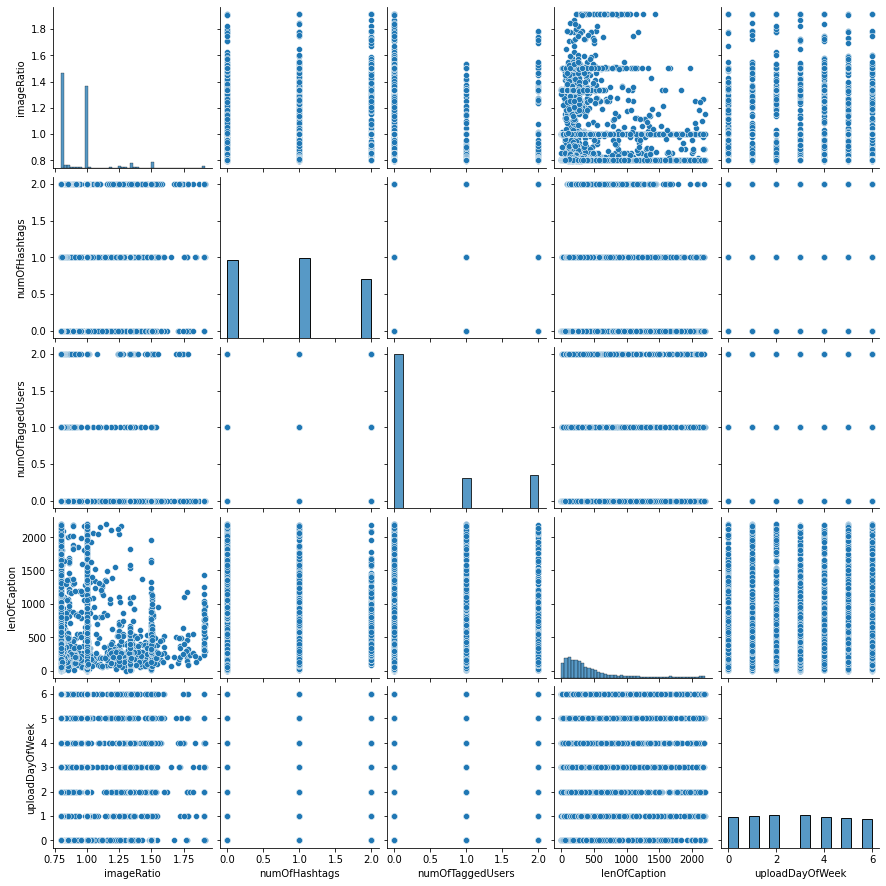

In [411]:
import seaborn as sns
figure=sns.pairplot(dfRegression.iloc[:,:5])
figure.savefig('pairplot2.png', dpi=300)

In [377]:
dfRegression.columns


imageRatio
numOfHashtags
numOfTaggedUsers
lenOfCaption
uploadDayOfWeek
airplane
apple
backpack
bear
bed
bench
bicycle
bird
boat
book
bottle
bowl
broccoli
bus
cake
car
cat
cell phone
chair
clock
couch
cow
cup
dining table
dog
donut
elephant
fire hydrant
fork
frisbee
giraffe
handbag
horse
hot dog
keyboard
kite
knife
laptop
microwave
motorcycle
mouse
orange
oven
person
pizza
potted plant
refrigerator
remote
sandwich
sheep
sink
skateboard
skis
spoon
sports ball
stop sign
suitcase
surfboard
teddy bear
tennis racket
tie
toilet
traffic light
train
truck
tv
umbrella
vase
wine glass
zebra
b_0
b_1
b_2
b_3
b_4
b_5
b_6
b_7
b_8
b_9
g_0
g_1
g_2
g_3
g_4
g_5
g_6
g_7
g_8
g_9
r_0
r_1
r_2
r_3
r_4
r_5
r_6
r_7
r_8
r_9
weightedLikes
logWeightedLikes


In [281]:
ht = '#Instalove #jj_forum #likers #followers #vsco #vscocam #sunset #sky #awesomeearth #bestvacations #photooftheday #igers #bestoftheday #instagood #wolderlust #cute #tbt #beautifuldestinations #skypainters #webstagram #cloudporn #landscape #instavsco #tagstsgram #pretty #picoftheday #wonderful_places #summer #postcardsfromtheworld'
postParams = {'numOfHashtags':len(ht.split('#')), 
              'numOfTaggedUsers':0, 
              'captionText':"Avenue of the Baobabs 🌴 Share your photos with us and we will post them in our account. Apply for a feature following the link in our bio: @earthfever \
Morondava, Madagascar. Photos by 1. @viajeros_360, 2. @lukewaitphotography, 3. @dearalyne, 4. @lukewaitphotography, 5. @justinfoulkes Tag who you want to visit this magical place with 💛",
              'uploadDayOfWeek':4}

imgUrls = ['https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/p640x640/179195907_148261227260951_2809210842564903086_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=111&_nc_ohc=HlUWArrU7vIAX9HOdpk&edm=AP_V10EBAAAA&ccb=7-4&oh=6bb6e3de2fd547707f16f517dbb3ded7&oe=60C58070&_nc_sid=4f375e',
          'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/p640x640/177772222_363088648457150_4653141578571906087_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=vl0nKmw71N0AX_8I9DT&tn=QjDx8IQPa7MXoya0&edm=AP_V10EBAAAA&ccb=7-4&oh=421df02794abf38ee7f9c4bd5ff07d2b&oe=60C577BD&_nc_sid=4f375e',
          'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/177389890_2890521711192982_4289264249920852830_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=110&_nc_ohc=jfDCjGrYHUEAX9o64pM&edm=AP_V10EBAAAA&ccb=7-4&oh=d516b461e69233fe745b845b3929526f&oe=60C72C21&_nc_sid=4f375e']
predictImageLikes(rsxgbr.best_estimator_, imgUrls[0], postParams, 2100000)

array([46406.95620328])

In [284]:
ht = '#Instalove #jj_forum #likers #followers #vsco #vscocam #sunset #sky #awesomeearth #bestvacations #photooftheday #igers #bestoftheday #instagood #wolderlust #cute #tbt #beautifuldestinations #skypainters #webstagram #cloudporn #landscape #instavsco #tagstsgram #pretty #picoftheday #wonderful_places #summer #postcardsfromtheworld'
postParams = {'numOfHashtags':len(ht.split('#')), 
              'numOfTaggedUsers':0, 
              'captionText':"Bella Italia 🥰🇮🇹Wanna see your pictures posted in our account? Apply for a feature on earthfever.net (link in my bio: @earthfever) \
1. Tremosine @cristinaproietti_photo \
2. Castle of Vicarello, Tuscany @gypseetravel \
3. Civitella del Tronto @chanel71forever \
4. Valle d'Itria, Ostuni @casaolivetta \
5. Sermoneta @sara.ciuffa \
6. Subiaco @eleonora_brusco \
7. Tivoli @p.saccucci \
8. Monteriggioni @paolo__66__ \
9. Firenze @emiz \
10. Erice @salvolobofiletti",
              'uploadDayOfWeek':4}

imgUrls = ['https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/p640x640/179195907_148261227260951_2809210842564903086_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=111&_nc_ohc=HlUWArrU7vIAX9HOdpk&edm=AP_V10EBAAAA&ccb=7-4&oh=6bb6e3de2fd547707f16f517dbb3ded7&oe=60C58070&_nc_sid=4f375e',
          'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/p640x640/177772222_363088648457150_4653141578571906087_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=vl0nKmw71N0AX_8I9DT&tn=QjDx8IQPa7MXoya0&edm=AP_V10EBAAAA&ccb=7-4&oh=421df02794abf38ee7f9c4bd5ff07d2b&oe=60C577BD&_nc_sid=4f375e',
          'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/177389890_2890521711192982_4289264249920852830_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=110&_nc_ohc=jfDCjGrYHUEAX9o64pM&edm=AP_V10EBAAAA&ccb=7-4&oh=d516b461e69233fe745b845b3929526f&oe=60C72C21&_nc_sid=4f375e']
predictImageLikes(rsxgbr.best_estimator_, imgUrls[1], postParams, 2100000)

array([47931.35561049])

In [285]:
ht = '#Instalove #jj_forum #likers #followers #vsco #vscocam #sunset #sky #awesomeearth #bestvacations #photooftheday #igers #bestoftheday #instagood #wolderlust #cute #tbt #beautifuldestinations #skypainters #webstagram #cloudporn #landscape #instavsco #tagstsgram #pretty #picoftheday #wonderful_places #summer #postcardsfromtheworld'
postParams = {'numOfHashtags':len(ht.split('#')), 
              'numOfTaggedUsers':0, 
              'captionText':"Follow @galahworld for more.  Tag your friends. Photo by @galahworld",
              'uploadDayOfWeek':4}

imgUrls = ['https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/p640x640/179195907_148261227260951_2809210842564903086_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=111&_nc_ohc=HlUWArrU7vIAX9HOdpk&edm=AP_V10EBAAAA&ccb=7-4&oh=6bb6e3de2fd547707f16f517dbb3ded7&oe=60C58070&_nc_sid=4f375e',
          'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/p640x640/177772222_363088648457150_4653141578571906087_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=vl0nKmw71N0AX_8I9DT&tn=QjDx8IQPa7MXoya0&edm=AP_V10EBAAAA&ccb=7-4&oh=421df02794abf38ee7f9c4bd5ff07d2b&oe=60C577BD&_nc_sid=4f375e',
          'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/177389890_2890521711192982_4289264249920852830_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=110&_nc_ohc=jfDCjGrYHUEAX9o64pM&edm=AP_V10EBAAAA&ccb=7-4&oh=d516b461e69233fe745b845b3929526f&oe=60C72C21&_nc_sid=4f375e']
predictImageLikes(rsxgbr.best_estimator_, imgUrls[2], postParams, 2100000)

array([42095.62484175])

In [291]:
imgUrl='https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/166817350_174092157883482_5885495520349088811_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=106&_nc_ohc=YR3_pfqFYCgAX_5uBHp&edm=AP_V10EBAAAA&ccb=7-4&oh=75d66afbefb611768fbfb73c77f1a719&oe=60C58E55&_nc_sid=4f375e'
postParams = {'numOfHashtags':3, 
              'numOfTaggedUsers':0, 
              'captionText':"Georgia is ❤️ #travels #georgia #borjomi",
              'uploadDayOfWeek':4}

print(predictImageLikes(rsxgbr.best_estimator_, imgUrl, postParams, 255))
print(imgUrl)

[5.655733]
https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/166817350_174092157883482_5885495520349088811_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=106&_nc_ohc=YR3_pfqFYCgAX_5uBHp&edm=AP_V10EBAAAA&ccb=7-4&oh=75d66afbefb611768fbfb73c77f1a719&oe=60C58E55&_nc_sid=4f375e


In [292]:
imgUrl = 'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/136957647_161183252104026_3417346556333846353_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=106&_nc_ohc=BynU36h4CFMAX_KgrAk&edm=AP_V10EBAAAA&ccb=7-4&oh=83537eb3c3d5ea9c402a70a53f031b6a&oe=60C6CA40&_nc_sid=4f375e'
#ht = '#Instalove #jj_forum #likers #followers #vsco #vscocam #sunset #sky #awesomeearth #bestvacations #photooftheday #igers #bestoftheday #instagood #wolderlust #cute #tbt #beautifuldestinations #skypainters #webstagram #cloudporn #landscape #instavsco #tagstsgram #pretty #picoftheday #wonderful_places #summer #postcardsfromtheworld'
postParams = {'numOfHashtags':0, 
              'numOfTaggedUsers':0, 
              'captionText':"🇹🇷☀️🎈",
              'uploadDayOfWeek':4}

print(predictImageLikes(rsxgbr.best_estimator_, imgUrl, postParams, 255))
print(imgUrl)

[5.208488]
https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/136957647_161183252104026_3417346556333846353_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=106&_nc_ohc=BynU36h4CFMAX_KgrAk&edm=AP_V10EBAAAA&ccb=7-4&oh=83537eb3c3d5ea9c402a70a53f031b6a&oe=60C6CA40&_nc_sid=4f375e


In [294]:
imgUrl = 'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/106004240_3584749304886912_8100138985509276403_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=100&_nc_ohc=hRmrJ2sezQkAX8IRyc0&edm=AP_V10EBAAAA&ccb=7-4&oh=cf12be671ee6c1224aa38e86d56b886e&oe=60C766E3&_nc_sid=4f375e'
#ht = '#Instalove #jj_forum #likers #followers #vsco #vscocam #sunset #sky #awesomeearth #bestvacations #photooftheday #igers #bestoftheday #instagood #wolderlust #cute #tbt #beautifuldestinations #skypainters #webstagram #cloudporn #landscape #instavsco #tagstsgram #pretty #picoftheday #wonderful_places #summer #postcardsfromtheworld'
postParams = {'numOfHashtags':0, 
              'numOfTaggedUsers':0, 
              'captionText':"",
              'uploadDayOfWeek':4}
print(predictImageLikes(rsxgbr.best_estimator_, imgUrl, postParams, 255))
print(imgUrl)


[3.572579]
https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/106004240_3584749304886912_8100138985509276403_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=100&_nc_ohc=hRmrJ2sezQkAX8IRyc0&edm=AP_V10EBAAAA&ccb=7-4&oh=cf12be671ee6c1224aa38e86d56b886e&oe=60C766E3&_nc_sid=4f375e


In [293]:
imgUrl = 'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/116418203_1164475343932969_7046003179980607143_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=101&_nc_ohc=brP0RxGzjXUAX8fXESP&edm=AP_V10EBAAAA&ccb=7-4&oh=0335e8e79f309ff833329803432b9543&oe=60C5CC28&_nc_sid=4f375e'
#ht = '#Instalove #jj_forum #likers #followers #vsco #vscocam #sunset #sky #awesomeearth #bestvacations #photooftheday #igers #bestoftheday #instagood #wolderlust #cute #tbt #beautifuldestinations #skypainters #webstagram #cloudporn #landscape #instavsco #tagstsgram #pretty #picoftheday #wonderful_places #summer #postcardsfromtheworld'
postParams = {'numOfHashtags':0, 
              'numOfTaggedUsers':0, 
              'captionText':"",
              'uploadDayOfWeek':4}

print(predictImageLikes(rsxgbr.best_estimator_, imgUrl, postParams, 255))
print(imgUrl)

[3.1837478]
https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/116418203_1164475343932969_7046003179980607143_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=101&_nc_ohc=brP0RxGzjXUAX8fXESP&edm=AP_V10EBAAAA&ccb=7-4&oh=0335e8e79f309ff833329803432b9543&oe=60C5CC28&_nc_sid=4f375e


In [296]:
imgUrl = 'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/e35/68735006_2676118645948444_5496531942336044973_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=104&_nc_ohc=lzCnQmobp9cAX9uqGKM&edm=AP_V10EBAAAA&ccb=7-4&oh=669312cd491a0235478c87f893a65de5&oe=60C6DB1B&_nc_sid=4f375e'
postParams = {'numOfHashtags':0, 
              'numOfTaggedUsers':0, 
              'captionText':"hanks to @surfbreakcamp for a wonderful vacation☀️🏄‍♀️🌊",
              'uploadDayOfWeek':4}

print(predictImageLikes(rsxgbr.best_estimator_, imgUrl, postParams, 255))
print(imgUrl)

[3.158806]
https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/e35/68735006_2676118645948444_5496531942336044973_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=104&_nc_ohc=lzCnQmobp9cAX9uqGKM&edm=AP_V10EBAAAA&ccb=7-4&oh=669312cd491a0235478c87f893a65de5&oe=60C6DB1B&_nc_sid=4f375e


In [272]:
np.exp(1)

2.718281828459045

In [237]:
columnsToFeed = dfRegression.columns
columnsToFeed

Index(['imageRatio', 'numOfHashtags', 'numOfTaggedUsers', 'lenOfCaption',
       'uploadDayOfWeek', 'airplane', 'apple', 'backpack', 'bear', 'bed',
       ...
       'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'r_9', 'weightedLikes',
       'logWeightedLikes'],
      dtype='object', length=107)

In [266]:
objectsList = columnsToFeed[5:-32]
objectsList

Index(['airplane', 'apple', 'backpack', 'bear', 'bed', 'bench', 'bicycle',
       'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake',
       'car', 'cat', 'cell phone', 'chair', 'clock', 'couch', 'cow', 'cup',
       'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork',
       'frisbee', 'giraffe', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite',
       'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven',
       'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich',
       'sheep', 'sink', 'skateboard', 'skis', 'spoon', 'sports ball',
       'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket',
       'tie', 'toilet', 'traffic light', 'train', 'truck', 'tv', 'umbrella',
       'vase', 'wine glass', 'zebra'],
      dtype='object')

In [245]:
imgUrl = 'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/p640x640/193323527_4004583532990253_6165528445726554309_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=105&_nc_ohc=AMEvsUWP0R0AX8PxinW&tn=QjDx8IQPa7MXoya0&edm=AP_V10EBAAAA&ccb=7-4&oh=975e4b9f1b12d36b0d73af76e83cc9d9&oe=60C65823&_nc_sid=4f375e'
imgUrl = 'https://instagram.fmxp5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/p640x640/192611616_160822559342304_1104131988075991008_n.jpg?tp=1&_nc_ht=instagram.fmxp5-1.fna.fbcdn.net&_nc_cat=100&_nc_ohc=kJqNEw_-lykAX9S28qV&edm=AP_V10EBAAAA&ccb=7-4&oh=c91b9c48a60ae552e78c82972b8ea5a6&oe=60C72E0F&_nc_sid=4f375e'
obj = getObjects(imgUrl, createDetector())

In [259]:
presentObjects = []
for o in obj:
    if o['percentage_probability']>=0.8:
        presentObjects.append(o['name'])
presentObjects = list(set(presentObjects))
presentObjects

['bird']

In [254]:
getColorData(imgUrl)

b_0       b_1     b_2       b_3       b_4       b_5       b_6  \
0  0.008607  0.136156  0.2431  0.190074  0.135322  0.139566  0.080893   

        b_7       b_8       b_9  ...       r_0       r_1      r_2       r_3  \
0  0.036012  0.018742  0.011527  ...  0.002213  0.019207  0.08466  0.315893   

        r_4       r_5       r_6       r_7       r_8       r_9  
0  0.261078  0.128562  0.059975  0.046055  0.043162  0.039195  

[1 rows x 30 columns]

In [240]:
from collections import defaultdict
dctP = defaultdict()
for c in columnsToFeed:
    dctP[c]=0
postParams = {'numOfHashtags':5, 
              'numOfTaggedUsers':2, 
              'captionText':'Hello',
              'uploadDayOfWeek':4}
for k in postParams:
    dctP[k]=postParams[k]
nFollowers = 2100000

dctP

defaultdict(None,
            {'imageRatio': 0,
             'numOfHashtags': 5,
             'numOfTaggedUsers': 2,
             'lenOfCaption': 0,
             'uploadDayOfWeek': 4,
             'airplane': 0,
             'apple': 0,
             'backpack': 0,
             'bear': 0,
             'bed': 0,
             'bench': 0,
             'bicycle': 0,
             'bird': 0,
             'boat': 0,
             'book': 0,
             'bottle': 0,
             'bowl': 0,
             'broccoli': 0,
             'bus': 0,
             'cake': 0,
             'car': 0,
             'cat': 0,
             'cell phone': 0,
             'chair': 0,
             'clock': 0,
             'couch': 0,
             'cow': 0,
             'cup': 0,
             'dining table': 0,
             'dog': 0,
             'donut': 0,
             'elephant': 0,
             'fire hydrant': 0,
             'fork': 0,
             'frisbee': 0,
             'giraffe': 0,
             'handbag': 